In [1]:
import json
import os

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_json_data(filename):
    filepath = os.path.join('..', 'data', filename)
    with open(filepath, 'r', encoding="utf-8") as file:
        return json.load(file)

# Load rooms and exits data
rooms_data = load_json_data('test_rooms.json')
exits_data = load_json_data('test_exits.json')

print(f"Loaded {len(rooms_data['rooms'])} rooms and {len(exits_data['exits'])} exits.")

Loaded 10 rooms and 17 exits.


In [3]:
# Create a directed multigraph
G = nx.MultiDiGraph()

# Add nodes to the graph
for room in rooms_data['rooms']:
    G.add_node(room['RoomID'], title=room['Title'])

# Create a dictionary to map ExitID to exit details
exit_map = {exit['ExitID']: exit for exit in exits_data['exits']}

# Add edges to the graph
for room in rooms_data['rooms']:
    for exit_id in room.get('ExitID', []):
        exit = exit_map.get(exit_id)
        if exit:
            G.add_edge(
                room['RoomID'],
                exit['TargetRoom'],
                key=exit_id,  # Use ExitID as the edge key
                direction=exit['Direction']
            )
        else:
            print(f"Warning: ExitID {exit_id} not found in exits data")

# Print basic information about the graph
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 10 nodes and 17 edges.


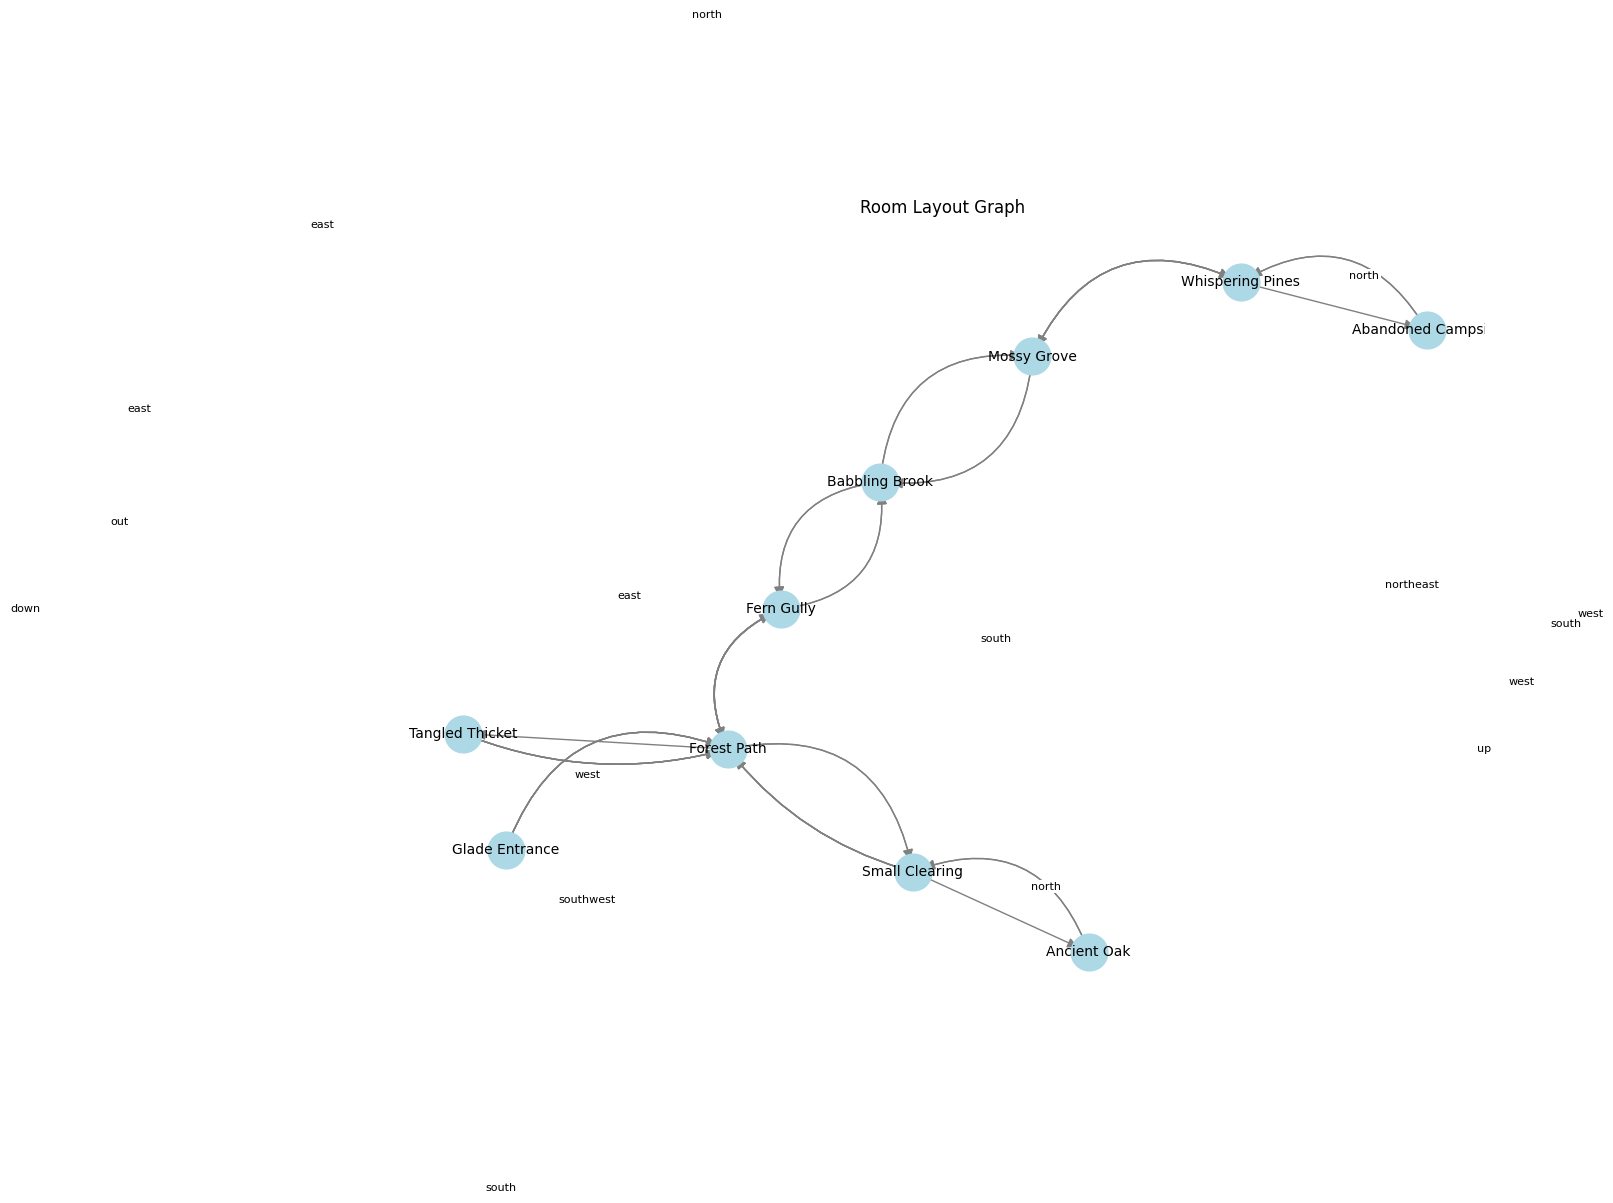

In [5]:
## Visualize the graph

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 10))  # Set the figure size as needed

# Position nodes using a layout algorithm with adjusted parameters
pos = nx.spring_layout(G, k=1.5, iterations=200)  # Adjust 'k' and 'iterations' as needed

# Draw nodes and labels on the ax object
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700, ax=ax)
node_labels = {node: G.nodes[node]['title'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, ax=ax)

# Prepare edge data
edge_list = list(G.edges(keys=True, data=True))
edge_counts = {}

# Count edges between nodes
for u, v, key, data in edge_list:
    edge_counts[(u, v)] = edge_counts.get((u, v), 0) + 1

# Draw edges with curvature and labels
for (u, v), count in edge_counts.items():
    # Get all edges between u and v
    edges = [(u, v2, k, d) for (u, v2, k, d) in edge_list if v2 == v]
    num_edges = len(edges)
    # Generate curvature values
    if num_edges == 1:
        rad_list = [0.0]
    else:
        rad_list = np.linspace(-0.5, 0.5, num_edges)

    for (u, v, key, data), rad in zip(edges, rad_list):
        # Draw the edge with curvature
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v, key)],
            connectionstyle=f'arc3,rad={rad}',
            arrowsize=15,
            edge_color='gray',
            ax=ax
        )
        # Calculate label position
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        # Midpoint of the edge
        xm, ym = (x1 + x2) / 2, (y1 + y2) / 2

        # Adjust label position based on curvature
        dx, dy = x2 - x1, y2 - y1
        angle = np.arctan2(dy, dx) + np.pi / 2
        distance = 0.1 + abs(rad) * 2.0  # Introduce a base distance and adjust multiplier
        label_x = xm + distance * np.cos(angle)
        label_y = ym + distance * np.sin(angle)

        # Add the edge label using ax.text
        label = data.get('direction', 'No Label')  # Handle missing 'direction' key
        ax.text(
            label_x,
            label_y,
            label,
            fontsize=8,
            ha='center',
            va='center',
            bbox=dict(facecolor='white', edgecolor='none', pad=1)
        )

# Set plot title and remove axes
ax.set_title("Room Layout Graph")
ax.axis('off')  # Uncomment if axes are unnecessary

# Display the plot
plt.show()
